# Link prediction example: GraphSAGE on the Cora citation dataset

In this example, we use our implementation of the [GraphSAGE](http://snap.stanford.edu/graphsage/) algorithm to build a model that predicts citation links in the Cora dataset (see below). The problem is treated as a supervised link prediction problem on a homogeneous citation network with nodes representing papers (with attributes such as binary keyword indicators and categorical subject) and links corresponding to paper-paper citations. 

To address this problem, we build a model with the following architecture. First we build a two-layer GraphSAGE model that takes labeled `(paper1, paper2)` node pairs corresponding to possible citation links, and outputs a pair of node embeddings for the `paper1` and `paper2` nodes of the pair. These embeddings are then fed into a link classification layer, which first applies a binary operator to those node embeddings (e.g., concatenating them) to construct the embedding of the potential link. Thus obtained link embeddings are passed through the dense link classification layer to obtain link predictions - probability for these candidate links to actually exist in the network. The entire model is trained end-to-end by minimizing the loss function of choice (e.g., binary cross-entropy between predicted link probabilities and true link labels, with true/false citation links having labels 1/0) using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' links fed into the model.

**References**

[1] Inductive Representation Learning on Large Graphs, W. L. Hamilton, R. Ying, and J. Leskovec, NIPS 2017


Copyright 2010-2019 Commonwealth Scientific and Industrial Research Organisation (CSIRO).

All Rights Reserved.

In [1]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification

import keras 
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar

Using TensorFlow backend.


### Loading the CORA network data

### Dataset


The dataset is the citation network Cora.

It can be downloaded by clicking [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz)

The following is the description of the dataset from the publisher,

> The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. The README file in the dataset provides more details. 

For this demo, we ignore the word vectors associated with each paper. We are only interested in the network structure and the **subject** attribute of each paper.

Download and unzip the cora.tgz file to a location on your computer. 

We assume that the dataset is stored in the directory

`../data/cora/`

where the files `cora.cites` and `cora.content` can be located.

We are going to load the data into a networkx object.

In [2]:
data_dir = os.path.expanduser("../data/cora")

In [3]:
cora_location = os.path.expanduser(os.path.join(data_dir, "cora.cites"))
g_nx = nx.read_edgelist(path=cora_location)

# load the node attribute data
cora_data_location = os.path.expanduser(os.path.join(data_dir, "cora.content"))
node_attr = pd.read_csv(cora_data_location, sep='\t', header=None)
values = { str(row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows()}
nx.set_node_attributes(g_nx, values, 'subject')

# Select the largest connected component. For clarity we ignore isolated
# nodes and subgraphs; having these in the data does not prevent the
# algorithm from running and producing valid results.
g_nx_ccs = (g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx))
g_nx = max(g_nx_ccs, key=len)
print("Largest subgraph statistics: {} nodes, {} edges".format(
    g_nx.number_of_nodes(), g_nx.number_of_edges()))

Largest subgraph statistics: 2485 nodes, 5069 edges


Load the features and subject for the nodes

In [4]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), 
                        sep="\t",  
                        header=None, 
                        names=column_names)
node_data.drop(['subject'], axis=1, inplace=True)


In [5]:
node_data.index = node_data.index.map(str)
node_data = node_data[node_data.index.isin(list(g_nx.nodes()))]

Define a set of node features that will be used by the model as the difference between the set of all node features and a list of user-defined node attributes to ignore:

In [6]:
ignore_attr = []
feature_names = sorted(set(node_data.columns) - set(ignore_attr))

We need to convert node features that will be used by the model to numeric values that are required for GraphSAGE input. Note that all node features in the Cora dataset, except the categorical "subject" feature, are already numeric, and don't require the conversion.

In [7]:
node_features = node_data[feature_names].values

In [8]:
node_features.shape

(2485, 1433)

Add node data to g_nx:

In [9]:
for nid, f in zip(node_data.index, node_features):
    g_nx.node[nid][globalvar.TYPE_ATTR_NAME] = "paper"  # specify node type
    g_nx.node[nid]["feature"] = f

We aim to train a link prediction model, hence we need to prepare the train and test sets of links and the corresponding graphs with those links removed.

We are going to split our input graph into a train and test graphs using the EdgeSplitter class in `stellargraph.data`. We will use the train graph for training the model (a binary classifier that, given two nodes, predicts whether a link between these two nodes should exist or not) and the test graph for evaluating the model's performance on hold out data.
Each of these graphs will have the same number of nodes as the input graph, but the number of links will differ (be reduced) as some of the links will be removed during each split and used as the positive samples for training/testing the link prediction classifier.

From the original graph G, extract a randomly sampled subset of test edges (true and false citation links) and the reduced graph G_test with the positive test edges removed:

In [10]:
# Define an edge splitter on the original graph g_nx:
edge_splitter_test = EdgeSplitter(g_nx)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 506 positive and 506 negative edges. **


The reduced graph G_test, together with the test ground truth set of links (edge_ids_test, edge_labels_test), will be used for testing the model.

Now repeat this procedure to obtain the training data for the model. From the reduced graph G_test, extract a randomly sampled subset of train edges (true and false citation links) and the reduced graph G_train with the positive train edges removed:

In [11]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 456 positive and 456 negative edges. **


G_train, together with the train ground truth set of links (edge_ids_train, edge_labels_train), will be used for training the model.

Convert G_train and G_test to StellarGraph objects (undirected, as required by GraphSAGE) for ML:

In [12]:
G_train = sg.StellarGraph(G_train, node_features="feature")
G_test = sg.StellarGraph(G_test, node_features="feature")

Summary of G_train and G_test - note that they have the same set of nodes, only differing in their edge sets:

In [13]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 4107

 Node types:
  paper: [2485]
        Attributes: {'feature', 'subject'}
    Edge types: paper-default->paper

 Edge types:
    paper-default->paper: [4107]



In [14]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 4563

 Node types:
  paper: [2485]
        Attributes: {'feature', 'subject'}
    Edge types: paper-default->paper

 Edge types:
    paper-default->paper: [4563]



Next, we create the link mappers for sampling and streaming training and testing data to the model. The link mappers essentially "map" pairs of nodes `(paper1, paper2)` to the input of GraphSAGE: they take minibatches of node pairs, sample 2-hop subgraphs with `(paper1, paper2)` head nodes extracted from those pairs, and feed them, together with the corresponding binary labels indicating whether those pairs represent true or false citation links, to the input layer of the GraphSAGE model, for SGD updates of the model parameters.

Specify the minibatch size (number of node pairs per minibatch) and the number of epochs for training the model:

In [15]:
batch_size = 20
epochs = 20

Specify the sizes of 1- and 2-hop neighbour samples for GraphSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model. In this example, we are defining a 2-layer GraphSAGE model.

In [16]:
num_samples = [20, 10]

In [17]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples).flow(edge_ids_train,edge_labels_train)
test_gen = GraphSAGELinkGenerator(G_test,  batch_size, num_samples).flow(edge_ids_test, edge_labels_test)

Build the model: a 2-layer GraphSAGE model acting as node representation learner, with a link classification layer on concatenated `(paper1, paper2)` node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 50 for both GraphSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive dropout rate, 0 < dropout < 1)
Note that the length of layer_sizes list must be equal to the length of num_samples, as len(num_samples) defines the number of hops (layers) in the GraphSAGE model.

In [ ]:
layer_sizes = [20, 20]
assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(
        layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
    )

In [21]:
x_inp, x_out = graphsage.build()

Final link classification layer that takes a pair of node embeddings produced by graphsage, applies a binary operator to them to produce the corresponding link embedding ('ip' for inner product; other options for the binary operator can be seen by running a cell with `?link_classification` in it), and passes it through a dense layer:

In [22]:
prediction = link_classification(
        output_dim=1, output_act="relu", edge_embedding_method='ip'
    )(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the GraphSAGE and prediction layers into a Keras model, and specify the loss

In [ ]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=["acc"],
    )

Evaluate the initial (untrained) model on the train and test set:

In [24]:
init_train_metrics = model.evaluate_generator(train_gen)
init_test_metrics = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Train Set Metrics of the initial (untrained) model:
	loss: 0.6733
	acc: 0.5987

Test Set Metrics of the initial (untrained) model:
	loss: 0.7140
	acc: 0.5939


Train the model:

In [25]:
history = model.fit_generator(
        train_gen,
        epochs=epochs,
        validation_data=test_gen,
        verbose=2
    )

Epoch 1/20
 - 11s - loss: 0.7208 - acc: 0.5800 - val_loss: 0.6828 - val_acc: 0.5988
Epoch 2/20
 - 8s - loss: 0.6287 - acc: 0.7159 - val_loss: 0.5939 - val_acc: 0.6630
Epoch 3/20
 - 8s - loss: 0.4745 - acc: 0.8080 - val_loss: 0.5960 - val_acc: 0.6808
Epoch 4/20
 - 8s - loss: 0.3834 - acc: 0.8482 - val_loss: 0.6262 - val_acc: 0.7006
Epoch 5/20
 - 8s - loss: 0.3361 - acc: 0.8848 - val_loss: 0.6704 - val_acc: 0.7767
Epoch 6/20
 - 8s - loss: 0.3420 - acc: 0.8855 - val_loss: 0.5940 - val_acc: 0.7322
Epoch 7/20
 - 8s - loss: 0.2973 - acc: 0.9109 - val_loss: 0.6204 - val_acc: 0.7688
Epoch 8/20
 - 8s - loss: 0.2519 - acc: 0.9326 - val_loss: 0.5893 - val_acc: 0.7638
Epoch 9/20
 - 8s - loss: 0.2390 - acc: 0.9525 - val_loss: 0.5522 - val_acc: 0.7678
Epoch 10/20
 - 8s - loss: 0.2055 - acc: 0.9565 - val_loss: 0.5865 - val_acc: 0.7866
Epoch 11/20
 - 8s - loss: 0.1955 - acc: 0.9609 - val_loss: 0.5832 - val_acc: 0.7787
Epoch 12/20
 - 8s - loss: 0.1861 - acc: 0.9576 - val_loss: 0.5902 - val_acc: 0.7658


Plot the training history:

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    
    f,axs = plt.subplots(1, len(metrics), figsize=(12,4))

    for m,ax in zip(metrics,axs):
        # summarize history for metric m
        ax.plot(history.history[m])
        ax.plot(history.history['val_' + m])
        ax.set_title(m)
        ax.set_ylabel(m)
        ax.set_xlabel('epoch')
        ax.legend(['train', 'test'], loc='upper right')

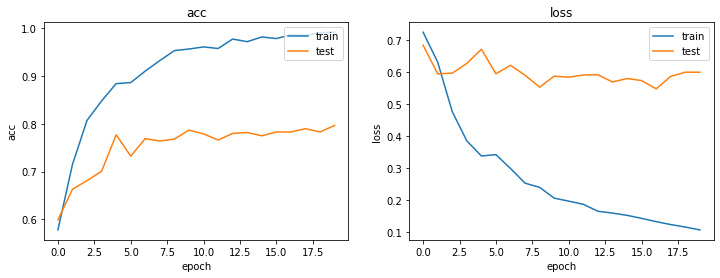

In [27]:
plot_history(history)

Evaluate the trained model on test citation links:

In [28]:
train_metrics = model.evaluate_generator(train_gen)
test_metrics = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Train Set Metrics of the trained model:
	loss: 0.0542
	acc: 0.9945

Test Set Metrics of the trained model:
	loss: 0.5704
	acc: 0.7984
